# L4 - Reinforcement learning

**Reinforcement learning** is one of the machine learning approaches, where our agent learns by interacting with the some environment. In contrast to the supervised learning there are no labeled objects. However, agent can get rewards, making some actions. The goal of the agent is to maximize the total reward over some time period. 

This lab is mainly based on the [book](http://incompleteideas.net/book/bookdraft2018jan1.pdf). You just must read it, if you are interesting in reinforcement learning.

### 1. Multi-armed bandit problem

#### Problem statement
##### Informal
Let we have $N$ slot machines. Playing on the $i$th slot, the agent receives some random reward. The agent doesn't know probability distribution of rewards, however it needs to maximize winnings after $T$ games.

##### Formal
Let $\mathcal{A}$ be a finite set of possible actions. For each action $a \in \mathcal{A}$ agent can get some reward which is determined by the unknown probability distribution $p(r|a)$. The strategy of the agent (policy) at time $t$ is some probability distribution on the set of actions – $\pi_t(a)$.

Games' steps:
> 1. Agent has some initial policy $\pi_1(a)$
> 2. At time  $1 \leq t \leq T$:
> 3. Agent randomly chooses action $a_t \sim \pi_t(a)$
> 4. Gets some reward $r_t \sim p(r|a_t)$
> 5. And update its policy $\pi_t \rightarrow \pi_{t+1}$

Let $c_t(a)$ be how many times action $a$ was used at  moment $t$
$$c_t(a) = \sum_{i=1}^{t}[A_i = a].$$
Then agent needs to minimize its regret
$$T\cdot\mu^* - \sum_a \mu_a \mathbb{E}[c_T(a)]$$
* $\mu_a$ – expected value of reward for action $a$
* $\mu^* = \max_a \mu_a$ – expected value of reward for optimal action

So we can define regrest as following
$$T\cdot\mu^* - \mathbb{E}\big[ \sum_{t=1}^{T} R_t \big].$$

The first task was formulated in this [paper](http://projecteuclid.org/download/pdf_1/euclid.bams/1183517370).
#### Model problem
1. $|A| = 100, T = 1000$
2. $\mu_a \sim \mathcal{N}(0, 1)$
3. $p(r|a) = \mathcal{N}(r; \mu_a, 1)$

The game simulated $10^4$ times and we are interesting in plot **[step]** $\times$ **[average total reward at current step]**.

1. $Q_t(a)$ – average reward of action $a$ by moment $t$ (value of action), $\lim_{c_t(a) \rightarrow \infty} Q_t(a) =\mu_a$.
2. $Q^*(a) = \lim_{t \rightarrow \infty} Q_t(a) = \mu_a$ – value of cation $a$.
3. $\mathcal{A}_t = \arg\max_a Q_t(a)$ – set of actions that has the greatest average reward at moment $t$.

#### Greedy policy
$$\pi_t(a)= \frac{1}{|\mathcal{A}_t|}[a \in \mathcal{A}_t].$$

#### Exercises
1. Implement gready policy.
2. What is main disadvantages?
3. How do you init $\pi$? Is there any better option?
4. Check this policy on model problem.

In [1]:
from __future__ import print_function
import numpy as np
import math
import matplotlib.pyplot as plt

In [2]:
A = 100

T = 1000

games_num = 1000

INF = 10 ** 10

mean = 0

sigma = 1

In [3]:
class Automat():
    def __init__(self, mean, sigma):
        self.m = mean
        self.s = sigma
        self.c = 0
    
    def reward(self):
        self.c += 1
        return np.random.normal(self.m, self.s)

In [4]:
class Automats():
    
    def __init__(self, mean, sigma, number):
        self.m = mean
        self.s = sigma
        self.n = number
        
        self.b = [] # automats themselves
        self.r = [] # and their average reward
        self.c = []
        
        for i in range(number):
            self.b.append(Automat(np.random.normal(self.m, self.s), sigma))
            self.r.append(0.0)
            self.c.append(0)
        
    def reward(self, action):
        r = self.b[action].reward() # get reward for action
        self.c[action] += 1
        
        self.r[action] = (self.r[action] * (self.b[action].c - 1) + r) / self.b[action].c # count new average reward for action
        
        return r

In [5]:
class Greedy():
    
    def __init__(self):
        self.policy = [1.0/A for i in range(A)]
    
    def change(self, automats):
        r = automats.r
        high = max(r) # max average reward
        count = 0 # how many automats have the same average reward as max one does
        
        for i in range(len(self.policy)):
            if (r[i] == high):
                count += 1
                
        for i in range(len(self.policy)): # set the policy right
            if (r[i] == high):
                self.policy[i] = 1.0 / count
            else:
                self.policy[i] = 0.0
        
        
    def action(self):
        index = [i for i in range(len(self.policy))]
        return np.random.choice(index, p=self.policy) # choose one randomly (uniform distribution)

In [6]:
def Game(Model):
    rew = np.array([0.0 for i in range(T + 1)]) # set reward for one game
    
    au = Automats(mean, sigma, A) # set casino
    
    for i in range(T):
        act = Model.action() # choose action due to the policy
        
        reward = au.reward(act) # get reward for the action
        
        rew[i + 1] = reward + rew[i]# account total reward
        
        Model.change(au) # change policy
        
    return rew

In [7]:
avg_rew_greedy = np.array([0.0 for i in range(T + 1)])

Model = Greedy()

for game in range(games_num):
    curr_rew = Game(Model)
    avg_rew_greedy = (avg_rew_greedy * (game) + curr_rew) / (game + 1)

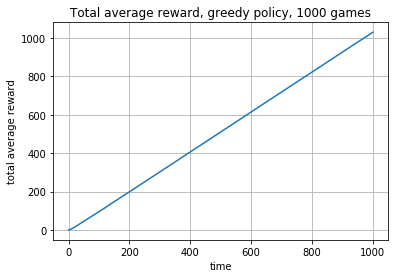

Total reward after 1000 games is equal to 1030.6593862072139


In [8]:
plt.plot(avg_rew_greedy)
plt.title("Total average reward, greedy policy, " + str(games_num) + " games")
plt.xlabel("time")
plt.ylabel("total average reward")
plt.grid(True)
plt.show()

print("Total reward after " + str(games_num) + " games is equal to " + str(avg_rew_greedy[T]))

#### $\varepsilon$-greedy policy
The previous approach only exploits the environment. However, agent should spend some time learning probability distribtion of rewards, to maximize its reward in the long term. Thus is a question of balance **exploration** and **exploitation**.

Possible improvement:
$$\pi_t(a)=\frac{1-\varepsilon}{|\mathcal{A}_t|}[a \in A_t] + \frac{\varepsilon}{|\mathcal{A}|},\ \varepsilon \in [0, 1].$$

#### Exercises
1. Implement this policy.
2. What happens if you increase $\varepsilon$?
3. How do you change $\varepsilon$ during agent learning?
4. Check this policy on model problem, using different $\varepsilon$.

In [9]:
class epsGreedy():
    def __init__(self, eps):
        self.policy = [1.0/A for i in range(A)]
        self.eps = eps
    
    def change(self, automats):
        r = automats.r
        high = max(r) # max average reward
        count = 0 # how many automats have the same average reward as max one does
        
        for i in range(len(self.policy)):
            if (r[i] == high):
                count += 1
                
        for i in range(len(self.policy)): # set the policy right
            if (r[i] == high):
                self.policy[i] = (1.0 - self.eps) / count + self.eps / A
            else:
                self.policy[i] = self.eps / A
        
        
    def action(self):
        index = [i for i in range(len(self.policy))]
        return np.random.choice(index, p=self.policy) # choose one randomly (uniform distribution)

In [10]:
avg_rew_egreedy = np.array([0.0 for i in range(T + 1)])

eps = 0.1

Model = epsGreedy(eps)

for game in range(games_num):
    curr_rew = Game(Model)
    avg_rew_egreedy = (avg_rew_egreedy * (game) + curr_rew) / (game + 1)

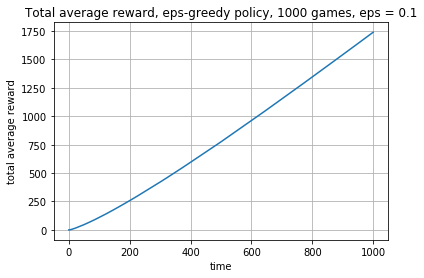

Total reward after 1000 games is equal to 1739.426854644217


In [11]:
plt.plot(avg_rew_egreedy)
plt.title("Total average reward, eps-greedy policy, " + str(games_num) + " games, eps = " + str(eps))
plt.xlabel("time")
plt.ylabel("total average reward")
plt.grid(True)
plt.show()

print("Total reward after " + str(games_num) + " games is equal to " + str(avg_rew_egreedy[T]))

#### Softmax
One more interpretation of $\varepsilon$-greedy policy

$$\pi_t(a)=\frac{\exp(\frac{1}{\varepsilon} \cdot Q_t(a))}{\sum_{b} \exp(\frac{1}{\varepsilon} \cdot Q_t(b))},\ \varepsilon >0.$$

#### Exercises
1. Implement this policy.
2. What happens if $\varepsilon \rightarrow 0$? What about $\varepsilon \rightarrow \infty$?
3. Compare softmax and $\varepsilon$-greedy policy on model problem.

In [12]:
class Softmax():
    def __init__(self, eps):
        self.policy = [1.0/A for i in range(A)]
        self.eps = eps
    
    def change(self, automats):
        r = automats.r
        s = 0.0
        for i in range(len(r)):
            s += np.exp(r[i] / self.eps)
        for i in range(len(self.policy)): # set the policy right
            self.policy[i] = np.exp(r[i] / self.eps) / s
        
        
    def action(self):
        index = [i for i in range(len(self.policy))]
        return np.random.choice(index, p=self.policy) # choose one randomly (uniform distribution)

In [13]:
avg_rew_softmax = np.array([0.0 for i in range(T + 1)])

eps = 0.3

Model = Softmax(eps)

for game in range(games_num):
    curr_rew = Game(Model)
    avg_rew_softmax = (avg_rew_softmax * (game) + curr_rew) / (game + 1)

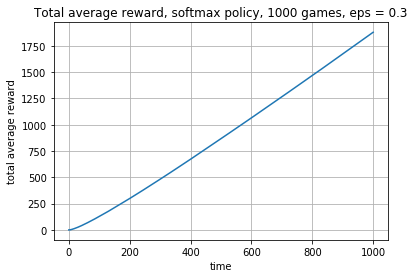

Total reward after 1000 games is equal to 1878.132576844013


In [14]:
plt.plot(avg_rew_softmax)
plt.title("Total average reward, softmax policy, " + str(games_num) + " games, eps = " + str(eps))
plt.xlabel("time")
plt.ylabel("total average reward")
plt.grid(True)
plt.show()

print("Total reward after " + str(games_num) + " games is equal to " + str(avg_rew_softmax[T]))

#### UCB (upper confidence bound)
For each moment $t$ agent defines the most potentially profitable actions. Agent choice of $a \in A_t$ in accordance with following rule
$$\mathcal{A}_t = \arg\max Q_t(a) + \varepsilon \sqrt{\frac{2 \ln t}{c_t(a)}},\ \varepsilon \geq 0$$

The first part is well known, but the second summand is measure of how accurate agent estimates $Q_t(a)$ at this moment. The policy itself balances between exploration and exploitation. This policy can be considired as optimal in some sense, more inforamtion [here](http://homes.di.unimi.it/~cesabian/Pubblicazioni/ml-02.pdf).

#### Exercises
1. Implement policy.
2. What happens if $\varepsilon \rightarrow 0$? What about $\varepsilon \rightarrow \infty$?
3. Compare this policy with softmax and $\varepsilon$-greedy policy.

In [15]:
class UCB():
    def __init__(self, eps):
        self.policy = [1.0/A for i in range(A)]
        self.eps = eps
    
    def change(self, automats):
        r = automats.r
        c = automats.c
        t = 0
        for i in range(len(c)):
            t += c[i]
        total = [0.0 for i in range(len(c))]
        for i in range(len(c)):
            total[i] = (r[i] + self.eps * np.sqrt(2 * np.log(t) / (c[i] + 1)))
        
        high = max(total)
        count = 0
        
        for i in range(len(total)):
            if (total[i] == high):
                count += 1
        for i in range(len(total)):
            if (total[i] == high):
                self.policy[i] = 1.0 / count
            else:
                self.policy[i] = 0.0
        
        
    def action(self):
        index = [i for i in range(len(self.policy))]
        return np.random.choice(index, p=self.policy) # choose one randomly (uniform distribution)

In [16]:
avg_rew_ucb = np.array([0.0 for i in range(T + 1)])

eps = 1

Model = UCB(eps)

for game in range(games_num):
    curr_rew = Game(Model)
    avg_rew_ucb = (avg_rew_ucb * (game) + curr_rew) / (game + 1)

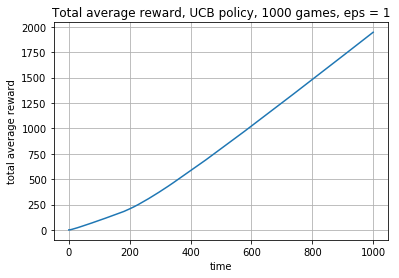

Total reward after 1000 games is equal to 1945.69106065477


In [17]:
plt.plot(avg_rew_ucb)
plt.title("Total average reward, UCB policy, " + str(games_num) + " games, eps = " + str(eps))
plt.xlabel("time")
plt.ylabel("total average reward")
plt.grid(True)
plt.show()

print("Total reward after " + str(games_num) + " games is equal to " + str(avg_rew_ucb[T]))

#### Gradient policy
There are also adaptive policy. They can be used, if the environment is not stationary (the distribution of rewards may slowly change). In this case, it is proposed to use the already familiar exponential smoothing
We find smoothed average reward at moment $t$ for all actions:
$$\bar{r}_{t+1} = (1-\alpha_t)\cdot\bar{r}_t(a)+\alpha_t r_{t+1} = \bar{r}_t +\alpha_t (r_{t+1}-\bar{r}_t(a)),\ \alpha_t \in [0, 1].$$

**Hint** Сonvergence condition
* $\sum^{\infty} \alpha_t = \infty$
* $\sum^{\infty} \alpha^2_t < \infty$

By the way, if $\alpha_t = \frac{1}{t}$, then $\bar{r}_{t+1}$ is just average of all $r_t$.

For each action we have some priority $p_t(a)$. After each step we make following update
$$p_{t+1}(a) = p_t(a)+\lambda(r_t-\bar{r}_t)(1-\pi_t(a)), \text{ $a$ is choosen,}$$

$$p_{t+1}(a) = p_t(a)-\lambda(r_t-\bar{r}_t)\pi_t(a), \text{ another case.}$$

So policy $\pi_{t+1}$ looks like:
$$\pi_{t+1}(a) = \frac{\exp(p_{t+1}(a))}{\sum_{b} \exp(p_{t+1}(b))}$$
More details about this method you can find in the book.

#### Exercise
1. Implement policy.
2. In conclusion, try to understand which model is better for our problem.

In [18]:
class Grad():
    def __init__(self, la):
        self.policy = [1.0/A for i in range(A)]
        self.l = la
        self.smooth = [0.0 for i in range(A)]
    
    def change(self, automats, action, time):
        alpha = 1.0 / time
        r = automats.r
        for i in range(len(r)):
            self.smooth[i] = (1 - alpha) * self.smooth[i] + alpha * r[i]
        
        p = [0.0 for i in range(len(self.policy))]
        for i in range(len(self.policy)):
            if (i == action):
                p[i] = self.policy[i] + self.l * (r[i] - self.smooth[i]) * (1 - self.policy[i])
            else:
                p[i] = self.policy[i] - self.l * (r[i] - self.smooth[i]) * self.policy[i]
        
        s = 0.0
        for i in range(len(p)):
            s += np.exp(p[i])
            
        for i in range(len(self.policy)):
            self.policy[i] = np.exp(p[i])/s
            
    def action(self):
        index = [i for i in range(len(self.policy))]
        return np.random.choice(index, p=self.policy) # choose with self.policy distribution

In [19]:
def Game_grad(Model):
    rew = np.array([0.0 for i in range(T + 1)]) # set reward for one game
    
    au = Automats(mean, sigma, A) # set casino
    
    for i in range(T):
        act = Model.action() # choose action due to the policy
        
        reward = au.reward(act) # get reward for the action
        
        rew[i + 1] = reward + rew[i]# account total reward
        
        Model.change(au, act, i + 1) # change policy
        
    return rew

In [20]:
avg_rew_grad = np.array([0.0 for i in range(T + 1)])

la = 0.001

Model = Grad(la)

for game in range(games_num):
    curr_rew = Game_grad(Model)
    avg_rew_grad = (avg_rew_grad * (game) + curr_rew) / (game + 1)

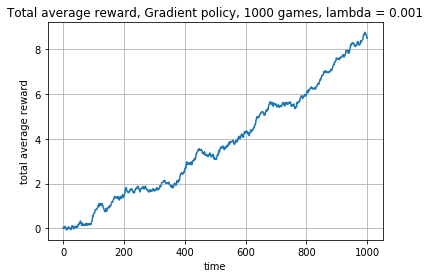

Total reward after 1000 games is equal to 8.488052471406055


In [21]:
plt.plot(avg_rew_grad)
plt.title("Total average reward, Gradient policy, " + str(games_num) + " games, lambda = " + str(la))
plt.xlabel("time")
plt.ylabel("total average reward")
plt.grid(True)
plt.show()

print("Total reward after " + str(games_num) + " games is equal to " + str(avg_rew_grad[T]))

### 2. Markov decison process
#### Problem statement
Now agent acts in some environment with finite set of states $\mathcal{S}$. At moment $t$ agent at state $s_t$ can choose action $a_t \in \mathcal{A}_{s_t} \subset \mathcal{A}$. After agent's action, environment moves it to state $s_{t+1}$ and give reward $r_{t+1}$. Environment behaviour is defined with
$$p(s_{t+1}, r_{t+1}|s_t, a_t)  = \Pr\{ S_{t+1} = s_{t+1}, R_{t+1} =  r_{t+1} | S_t = s_t, A_t = a_t\}.$$

Agent has some policy $\pi$, which at moment $t$ defines probabilty of action $a_t \in \mathcal{A}_{s_t}$ for state $s_t$ $\pi_t(a_t|s_t) = p(a_t|s_t)$. Informally agent needs to maximize the total reward. If the decision process is finite, the problem is formalized as maximizing
$$G = \sum_{t=0}^{T} R_{t+1},$$
here $T$ – moment of time, when agent achives final state. We will consider this value as a random. If the process can last very long or infinite time than we have dealing with a discounted reward
$$ G_t = \sum_{k=0}^{\infty} \gamma^{k} R_{t+k+1},$$
here $\gamma \in [0, 1]$ defines how deep we look into the future.

The probability that the process moves into its new state is influenced by the chosen action. Specifically, it is given by the state transition function. Thus, the next state  depends on the current state and the decision maker's action. But given state and action, it is conditionally independent of all previous states and actions, in other words, the state transitions of an MDP satisfies the Markov property.

#### Exercises
1. Give life example of Markov decision process (it may be any game, etc.).
2. Can you give an example where a decision can't be modeled with a Markov process?
3. Using $p(s_{t+1}, r_{t+1}|s_t, a_t)$, find values below (all distribution are discrete):
  * $r(s_{t}, a_{t}) = \mathbb{E}[R_{t+1}|S_t = s_t, A_t = a_t]$ – average reward for action $a_t$ in state $s_t$ 
  * $p(s_{t+1} | s_t, a_t) = \Pr\{S_{t+1} = s_{t+1} | S_t = s_t, A_t = a_t \}$ – probability to move from $s_t$ to $s_{t+1}$, making $a_t$.
  * $r(s_t, a_t, s_{t+1}) = \mathbb{E}[R_{t+1}|S_{t+1} = s_{t+1}, S_t = s_t, A_t = a_t]$ – average reward when moving from $s_t$ to $s_{t+1}$, making $a_t$.

#### Main definitions 
State-value function under the strategy of $\pi$ returns for state $s$ total reward, that agent gets, starting from $s$
$$V^\pi(s) = \mathbb{E}[G_t|S_t=s] = \mathbb{E}\Big[\sum_{k=0}^{\infty} \gamma^{k+1}R_{t+k+1}|S_t=s\Big].$$

Action-value function under the strategy $\pi$ for action $a$ and state $s$ returns total reward that agent gets, starting from $s$ and making $a$
$$Q^\pi(s, a) = \mathbb{E}[G_t|S_t=s, A_t=a] = \mathbb{E}\Big[\sum_{k=0}^{\infty} \gamma^{k+1}R_{t+k+1}|S_t=s,  A_t=a\Big].$$

Thus we have following equations (the first two are Bellman equations):

$$V^{\pi}(s) = \mathbb{E}\big[R_{t+1} + \gamma V^{\pi}(S_{t+1}) | S_t=s\big]$$

$$Q^{\pi}(s, a) = \mathbb{E}\big[R_{t+1} + \gamma Q^{\pi}(S_{t+1}, A_{t+1}) | S_t=s, A_t=a\big]$$

$$Q^{\pi}(s, a) = \mathbb{E}\big[R_{t+1} + \gamma V^{\pi}(S_{t+1}) | S_t=s, A_t=a\big]$$

#### Remark
It is important to note that policy $\pi$ is fixed and doesn't change with time. Although in real practice it is not true, because our strategy is constantly updating when agent learns environment.
Policy $\pi^{*}$ is optimal, if for each state $s$ and any other policy $\pi$ it is true that $V_{\pi^{*}}(s) \geq V_{\pi}(s)$. Posibly, there are several different optimal policies, however functions $V(s)$ and $Q(s, a)$, which they defines are the same. So, we denote these functions $V^*(s)$ и $Q^*(s, a)$ as optimal.

Equations below are Bellman optimality equations (more info [here](https://en.wikipedia.org/wiki/Bellman_equation):
$$V^*(s) = \max_{a \in \mathcal{A}} \mathbb{E}\big[R_{t+1} + \gamma V^*(S_{t+1}) | S_t=s, A_t=a\big]$$
$$Q^*(s, a) = \mathbb{E}\big[R_{t+1} + \gamma \max_{b \in \mathcal{A}} Q^*(S_{t+1}, b) | S_t=s, A_t=a\big]$$

Then the following two greedy strategies are equivalent and optimal ($\mathcal{A}_t$ – set):
$$\mathcal{A}_t = \arg\max_{a \in \mathcal{A}} \mathbb{E}\big[R_{t+1} + \gamma V^*(s_{t+1}) | s_t, a \big]$$
$$\mathcal{A}_t = \arg\max_{a \in \mathcal{A}} Q^*(s_t, a)$$

#### Dynamic programming
This part is based on the fact, that $p(s',r|s,a)$ is known.

#### Iterative policy evaluation
Let agent has some fixed policy $\pi$, then for $V^{\pi}$ we have
$$V^{\pi}(s) = \sum_a \pi(a|s) \sum_{s',r} p(s',r|s,a) \big[r + \gamma V^{\pi}(s') \big]$$

For simplicity we assume that the distribution of rewards is discrete random variable. Otherwise, it is necessary to use operator of integration instead of sum. For each state $s$ we can can evaluate $V^{\pi}$, using iterative algorithm ($V_0$ is initialized randomly)
$$V_{n+1}(s) = \sum_a \pi(a|s) \sum_{s',r} p(s',r|s,a) \big[r + \gamma V_n(s') \big].$$

By the way, if $s$ is a final state, then $V(s)$ is already known and we may use this value as initialization for faster convergence. The computation stops when $V(s)$ varies negligible from iteration to iteration.

#### Remarks
1. We make assumption that $p(s',r|s,a)$ is known, but it's often not truth in practice.
2. Compution of $V_{n+1}$ can be done **in place**, it accelerates convergence, since in the process of computation we will use the values from iteration $n$ and some new values from iteration $n+1$.

#### Policy improvement theorem
Suppose there are policies $\pi$ and $\pi'$, and for each state $s$ we have
$$Q^{\pi}(s, \pi'(s)) \geq V^{\pi}(s),$$
then the following inequality holds
$$V^{\pi'}(s) \geq V^{\pi}(s).$$

The main interest of this theorem is that it allows us to improve the current policy. We know how to calculate $V^{\pi}(s)$, so

$$
Q^{\pi}(s, a) =
\mathbb{E}\big[R_{t+1} + \gamma V^{\pi}(S_{t+1}) | S_t=s, A_t=a\big] =
\sum_{s',r}p(s',r|s, a)\big[ r + \gamma V^{\pi}(s') \big]
$$

In this way we can improve our policy
$$\pi'(a) = \arg\max_a Q^{\pi}(s, a).$$
The writing above means, that policy chooses action uniformly among all optimal actions. If we can't improve $V^{\pi}$, then out state-value function is optimal and satisfies the equation the Bellman equation. So, policy, which defines this policy, is also optimal.

#### Policy interation
Performing alternately calculation of $V^{\pi}$ and improving $\pi$, we can find optimal policy $\pi^*$. It should be noted that as initialization values of $V(s)$ you may use state-value function from previous iteration, it helps significantly speeds up the convergence of the algorithm.

#### Value interation
There is also interesting approach to compute $V^{*}(s)$ of optimal strategy $\pi^{*}$
$$V_{n+1}(s) = \max_a \sum_{s',r} p(s',r|s,a) \big[r + \gamma V_n(s') \big].$$

You may understand this method in the following way. On the one hand we in greedy manner update state value function during each iteration of value function evaluation. On the other hand we use Bellman equation to evaluate $V^{*}$ iteratively. It's rather practical method.

#### Exercises
1. Let you environment have 100 states. The distribution function $p(s',r|s,a)$ may be defined by your own.
2. Fix some discount value and find optimal policy.
3. What method is faster? For any state $s$, check how $V^*(s)$ varies during $\gamma$ changing.
4. Plot $\gamma \times V^*(s)$ for some 5 states.

### 3. Model problem
As a model problem we choose tic-tac-toe game. One agent plays against another, so environament for each player is its opponent. The set of states $\mathcal{S}_{X}$ is all possible positions of tic-tac-toe game for Xs and the set $\mathcal{S}_{O}$ defined in the same way for Os. You need to train both agents during some series of games where they play with each other. The criterion of success – both agent don't lose human.

### 4. Temporal difference
The speech will focus on more practical methods. Let imagine that we evaluate $V^{\pi}(s)$ for our policy $\pi$. Our agent visited state $s_t$ and we know total reward $G_t$. When agent visites the state $s_t$, we can improve estimation of $V^{\pi}$ using exponential smoothing
$$V^{\pi}_{n+1}(s_t) = V_{n}^{\pi}(s_t) + \alpha \big(G_t - V_{n}^{\pi}(s_t)\big).$$

However, you can make some trick and rewrite $G_t$
$$V_{n+1}^{\pi}(s_t) = V_{n}^{\pi}(s_t) + \alpha \big(R_t + \gamma V^{\pi}(S_{t+1}) - V_{n}^{\pi}(s_t)\big),$$
so we can update $V^{\pi}(s_t)$ after each visiting $s_t$. Similarly, we can compute
$$Q_{n+1}(s_t, a_t) = Q_{n}(s_t, a_t) + \alpha \big(R_{t+1} + \gamma Q^{\pi}(S_{t+1}, A_{t+1}) - Q_{n}^{\pi}(s_t, a_t)\big).$$

#### SARSA (State-Action-Reward-State-Action)
So, we want to find optimal policy $\pi^{*}$. Let's suppose we have some initial approximation $Q(s, a)$. We use нее $\varepsilon$-greedy policy $\mathcal{A}_s = \arg\max_{a \in \mathcal{A}} Q(s, a)$. 

$$\pi(a|s)=\frac{1-\varepsilon}{|\mathcal{A}_s|}[a \in \mathcal{A}_s] + \frac{\varepsilon}{|\mathcal{A}|},\ \varepsilon \in [0, 1].$$

In accordance with policy $\pi$ we choose $a_t$ and get reward $R_{t+1}$, after that environment move agent to state $S_{t+1}$. Agent one more time choose action $A_{t+1} \sim \pi(a|S_{t+1})$ and doesn't act in the environemnt, but only update $Q$ function
$$Q(s_t, a_t) = Q(s_t, a_t) + \alpha \big(R_{t+1} + \gamma Q^{\pi}(S_{t+1}, A_{t+1}) - Q^{\pi}(s_t, a_t)\big).$$

Also, there is more variation of this idea, that uses expected Q-value.
$$Q(s_t, a_t) = Q(s_t, a_t) + \alpha \big(R_{t+1} + \gamma \sum_b \pi(b|S_{t+1}) Q^{\pi}(S_{t+1}, b) - Q^{\pi}(s_t, a_t)\big).$$
So we use $\varepsilon$-greedy approach to improve our policy and evaluate.

####  Q-learning
The idea of this method is rather similar, but we also greedy update action-value function $Q$ 
$$Q(s_t, a_t) = Q(s_t, a_t) + \alpha \big(R_{t+1} + \gamma \max_{b} Q(S_{t+1}, b) - Q(s_t, a_t)\big).$$ For choosing actions during learning agent can use any policy, e.g. $\varepsilon$-greedy or softmax policy.

#### Exercises
1. Implement both algorithm for our model problem.
2. Which one converges faster? How can you estimate it?
3. Compare how action-value function $Q(s_t, a_t)$ differs for these two methods.
4. Try to play with your agents...
5. Use intentionally losing strategy for Os. What happened?
6. Try to beat the agent for Xs.